# ASAS-SN Lightcurve

Let's spot-check the ASAS-SN lightcurve!

In [1]:
%config Completer.use_jedi = False

In [2]:
import lightkurve as lk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Read in the ASAS-SN data

In [4]:
#! mv /home/gully/Downloads/light_curve_d9150dcd-71fb-4778-b7dc-5b1aca260ee1.csv ../../data/ASASSN/

In [5]:
#! head ../../data/ASASSN/light_curve_d9150dcd-71fb-4778-b7dc-5b1aca260ee1.csv

In [6]:
df = pd.read_csv('../../data/ASASSN/light_curve_d9150dcd-71fb-4778-b7dc-5b1aca260ee1.csv')

In [7]:
df['BTJD'] = df.HJD - 2457000.0

In [8]:
sentinel_value = 99.990
bad_data = df['flux(mJy)'] == sentinel_value

In [9]:
df = df[~bad_data]

In [10]:
df_V = df[df.Filter == 'V'].reset_index(drop=True)
df_g = df[df.Filter == 'g'].reset_index(drop=True)

In [11]:
scalar_constant = np.nanmedian(df_V['flux(mJy)'])
df_V['flux'] = df_V['flux(mJy)']/scalar_constant
df_V['flux_err'] = df_V.flux_err/scalar_constant

In [12]:
scalar_constant = np.nanmedian(df_g['flux(mJy)'])
df_g['flux'] = df_g['flux(mJy)']/scalar_constant
df_g['flux_err'] = df_g.flux_err/scalar_constant

In [13]:
df_g.Camera.value_counts()

bs    718
bC    670
bt      3
Name: Camera, dtype: int64

In [14]:
# Read in the TESS Lightcurve too

In [15]:
sr = lk.search_lightcurve('HAT-P-67')

In [16]:
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 24,2020,SPOC,120,198588220,0.0
...,...,...,...,...,...,...
4,TESS Sector 26,2020,TESS-SPOC,1800,198588220,0.0
5,TESS Sector 26,2020,QLP,1800,198588220,0.0


In [17]:
lcs = sr[[1,4]].download_all()
lc = lcs.stitch().normalize()

In [18]:
lc.time, lc.flux

(<Time object: scale='tdb' format='btjd' value=[1955.82500507 1955.84583883 1955.86667258 ... 2035.0750145  2035.09584739
  2035.11668028]>,
 <MaskedQuantity [0.9992334 , 0.9990896 , 0.99922407, ..., 0.9956385 ,
                  0.9958207 , 0.99602365]>)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

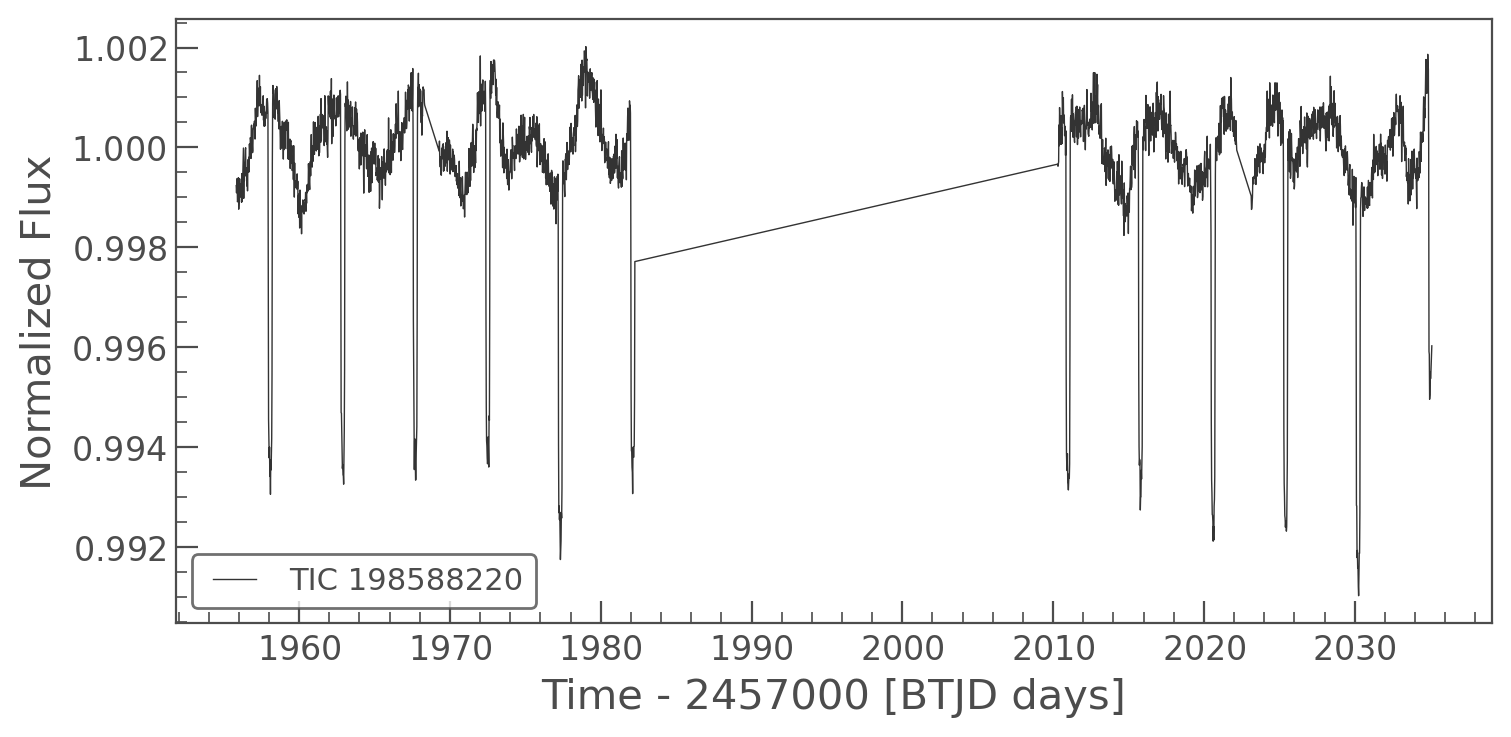

In [24]:
lc.plot()

Text(0, 0.5, 'Flux')

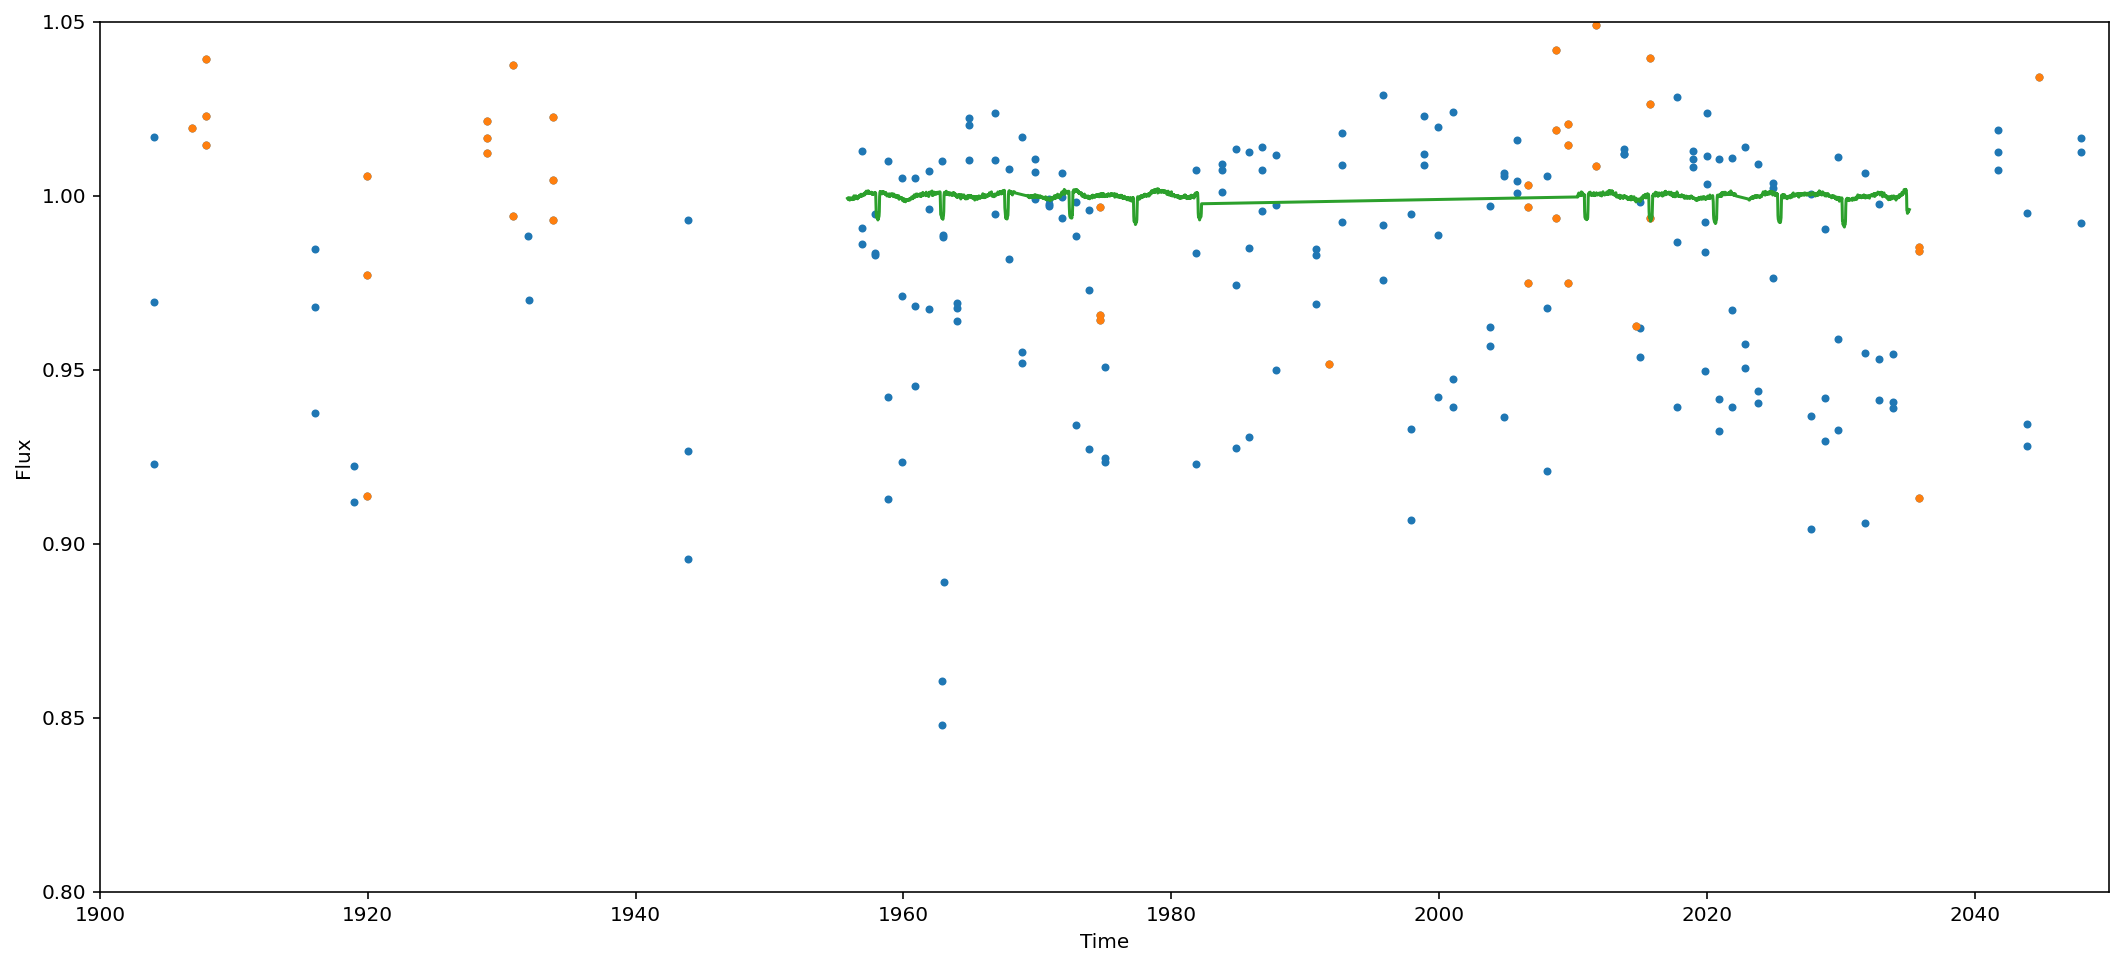

In [28]:
plt.figure(figsize=(18, 8))
plt.plot(df_g['BTJD'], df_g['flux'], '.');
mask = df_g.Camera == 'bs'
plt.plot(df_g['BTJD'][mask], df_g['flux'][mask], '.');

plt.plot(lc.time.value, lc.flux)

#plt.plot(df_V['BTJD'], df_V['flux'], 'o');

plt.xlim(1900, 2050)
plt.ylim(0.8, 1.05)
plt.xlabel('Time')
plt.ylabel('Flux')
#plt.xlim(2200)

In [40]:
df_V['flux_err'] += 0.01

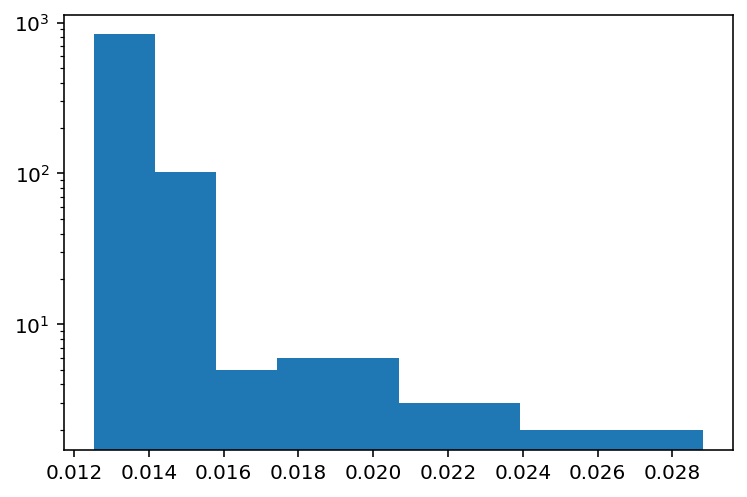

In [41]:
plt.hist(df_V.flux_err)
plt.yscale('log')

## Make an ASASSN Periodogram

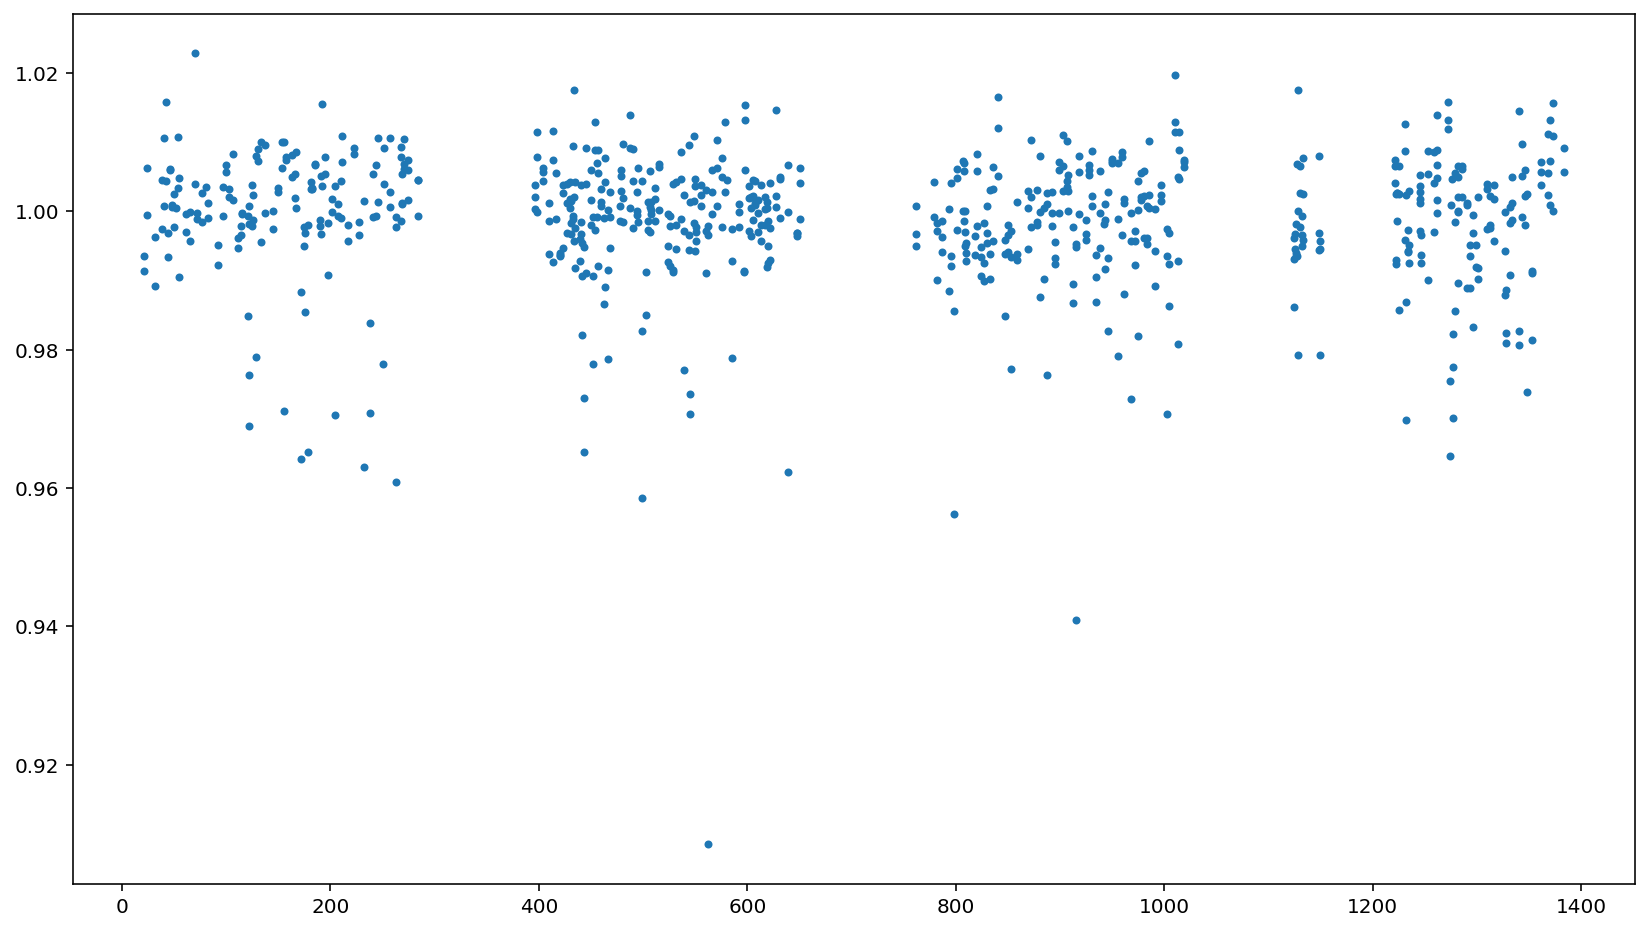

In [65]:
df_V = df_V[df_V.BTJD > 0] 

plt.figure(figsize=(14, 8))
plt.plot(df_V.BTJD, df_V.flux, '.')

In [66]:
lc_asassn = lk.LightCurve(time=df_V.BTJD.values, 
                          flux=df_V.flux.values, 
                          flux_err=df_V.flux_err.values)

In [67]:
import astropy.units as u

In [114]:
pg = lc_asassn.to_periodogram(minimum_period=2.1*u.day, maximum_period=40.3*u.day, 
                              oversample_factor=20.0, ls_method='slow', nterms=4)

In [115]:
pg.period_at_max_power

<Quantity 29.54983526 d>

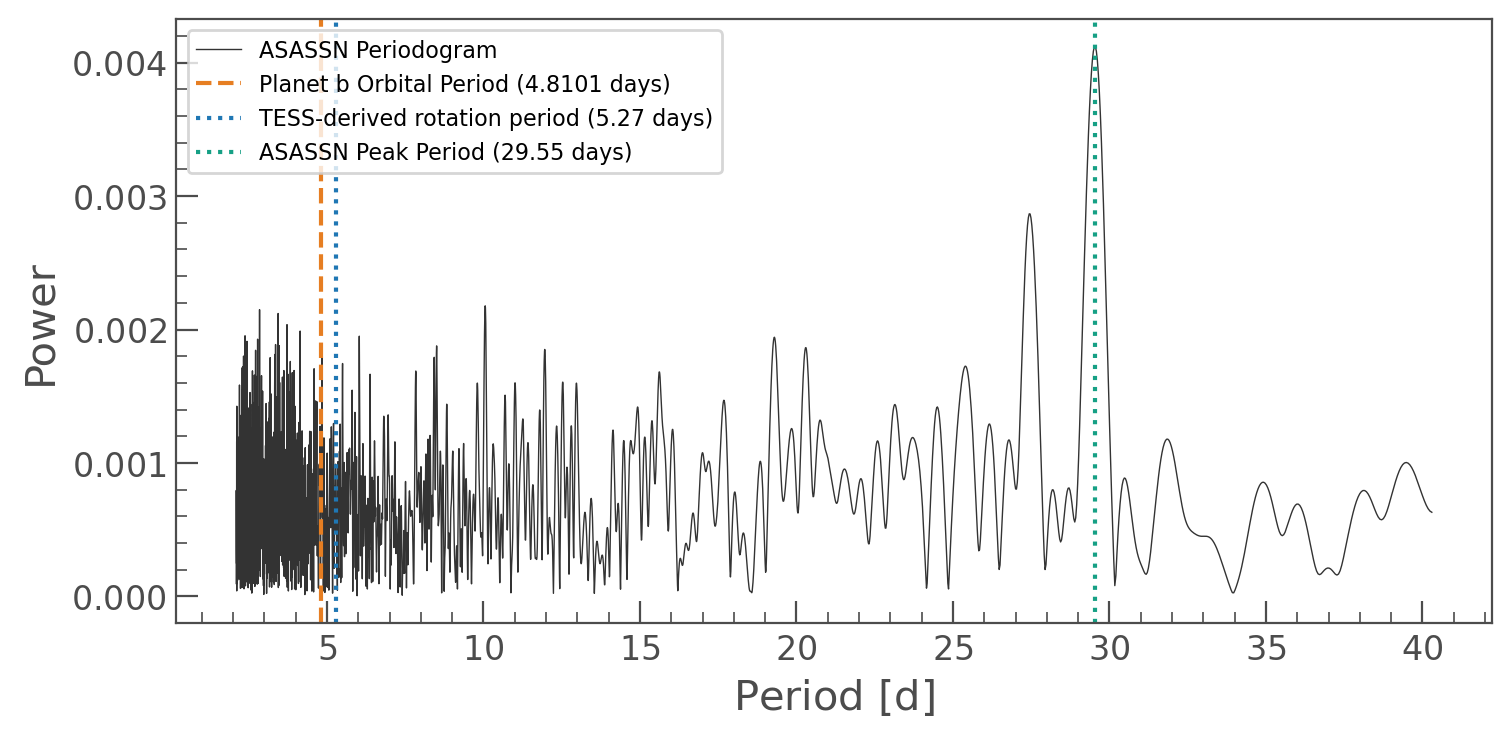

In [120]:
ax = pg.plot(label='ASASSN Periodogram')
ax.axvline(4.8101, linestyle='dashed', 
           label='Planet b Orbital Period (4.8101 days)', color='#e67e22')
ax.axvline(5.27483, linestyle='dotted', 
           label='TESS-derived rotation period (5.27 days)')
ax.axvline(pg.period_at_max_power.value, linestyle='dotted', 
           label='ASASSN Peak Period (29.55 days)', color='#16a085')

ax.legend(fontsize=8)

In [110]:
btjd_T0 = 2455961.38467 - 2457000.0

In [111]:
pg.model(lc_asassn.time).fold(pg.period_at_max_power)

time,flux,flux_err,time_original
,,,
TimeDelta,float64,float64,Time
-14.597609087064297,1.0004825358232192,nan,479.07362999999896
...,...,...,...
14.702922728219212,1.0002835822121963,nan,153.9995900001377


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

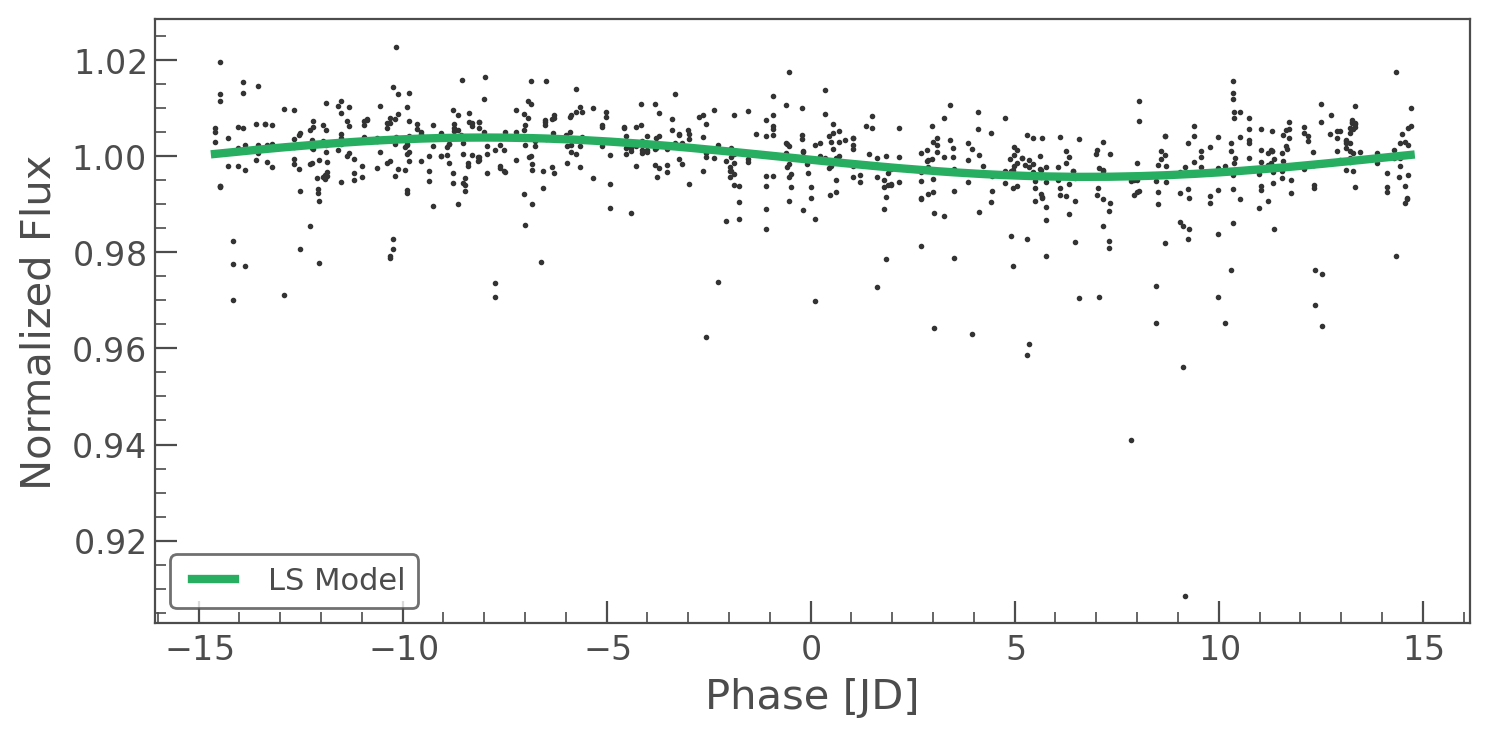

In [112]:
ax = lc_asassn.fold(pg.period_at_max_power).scatter()
pg.model(lc_asassn.time).fold(pg.period_at_max_power).plot(ax=ax, color='#27ae60', linewidth=3)

In [89]:
(-5.27**-1 + 4.8101**-1)**-1

27.55949880408785

In [4]:
sr = lk.search_lightcurve('HAT-P-67')

In [5]:
sr_2 = lk.search_targetpixelfile('HAT-P-67') #data cube: add up pixels in each picture

In [7]:
sr_3 = lk.search_tesscut('HAT-P-67') #data cube: add up pixels in each picture

In [10]:
sr_3

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 24,2020,TESScut,1426,HAT-P-67,0.0
1,TESS Sector 25,2020,TESScut,1426,HAT-P-67,0.0
2,TESS Sector 26,2020,TESScut,1426,HAT-P-67,0.0


In [11]:
tpf_raw = sr_2[0].download() #use interact()

In [16]:
lc_raw = sr[1].download().normalize()

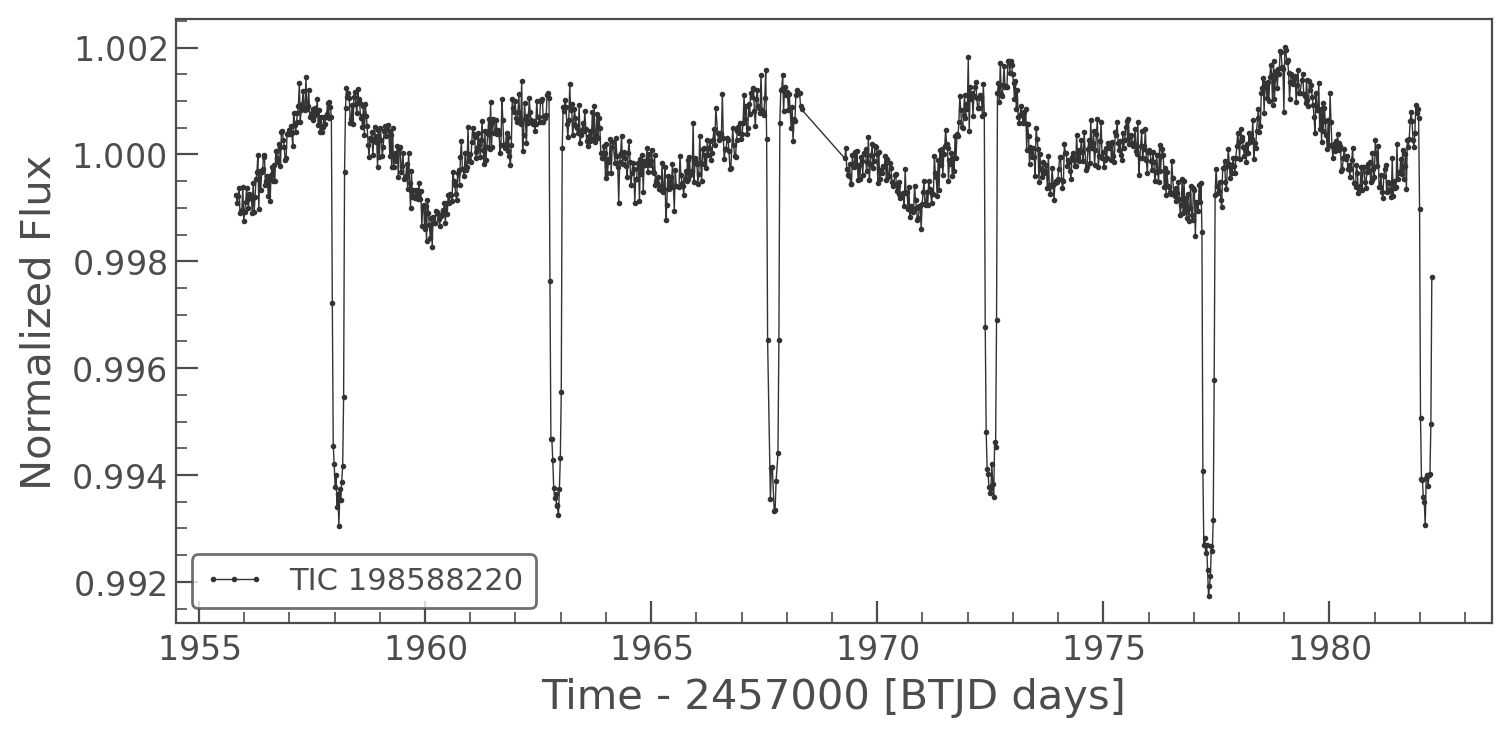

In [17]:
ax = lc_raw.plot(marker='.', linestyle=None)
#ax.set_ylim(0, 1.05)
plt.savefig('../../figures/HAT-P-67_TESS.png')

The star flux changes by about +/- 0.2%, and the exoplanet transit depth is about 0.7%.  We want to temporarily remove the star's variation so that we can isolate the exoplanet transit signal.

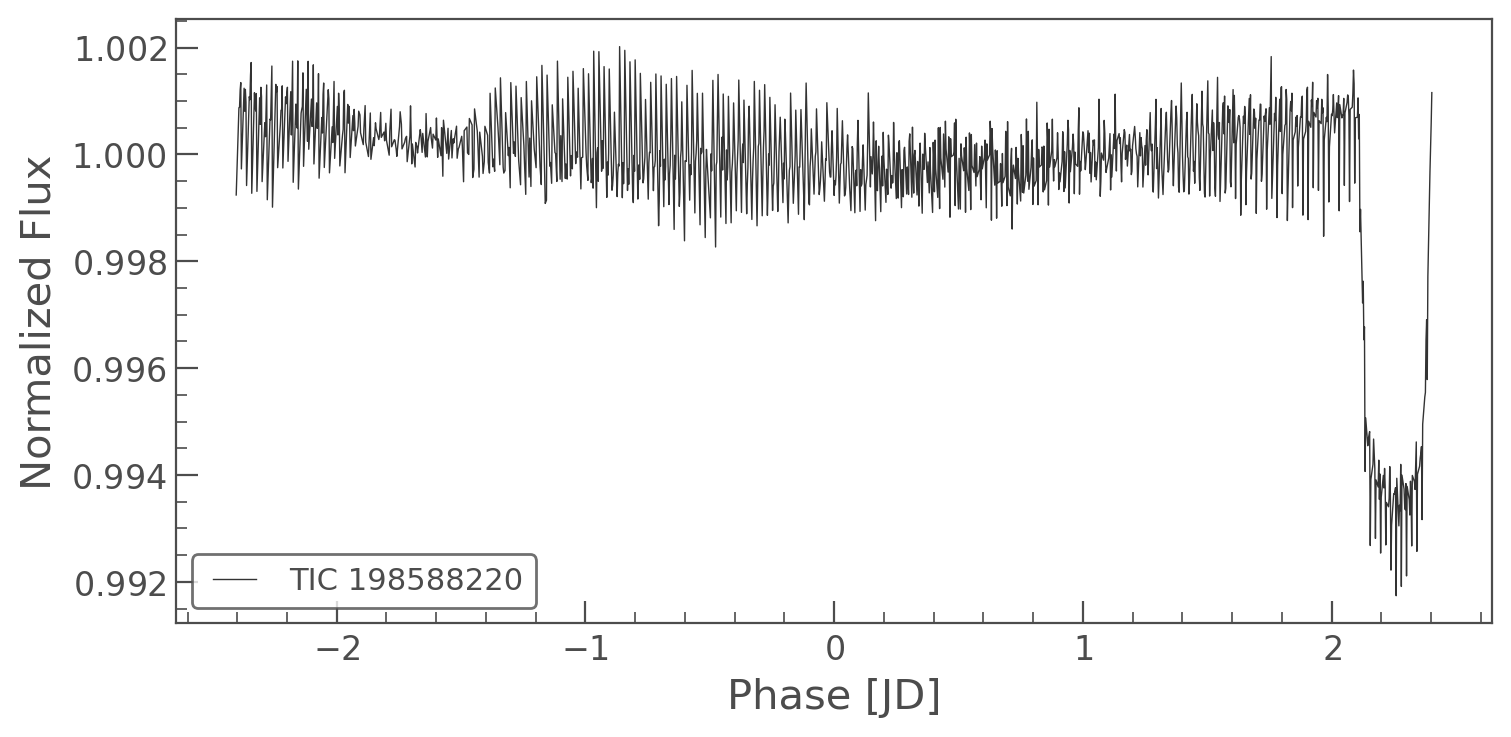

In [18]:
planet_period = 4.81010250
lc_raw.fold(period=planet_period).plot();

In [19]:
pg = lc_raw.to_periodogram()

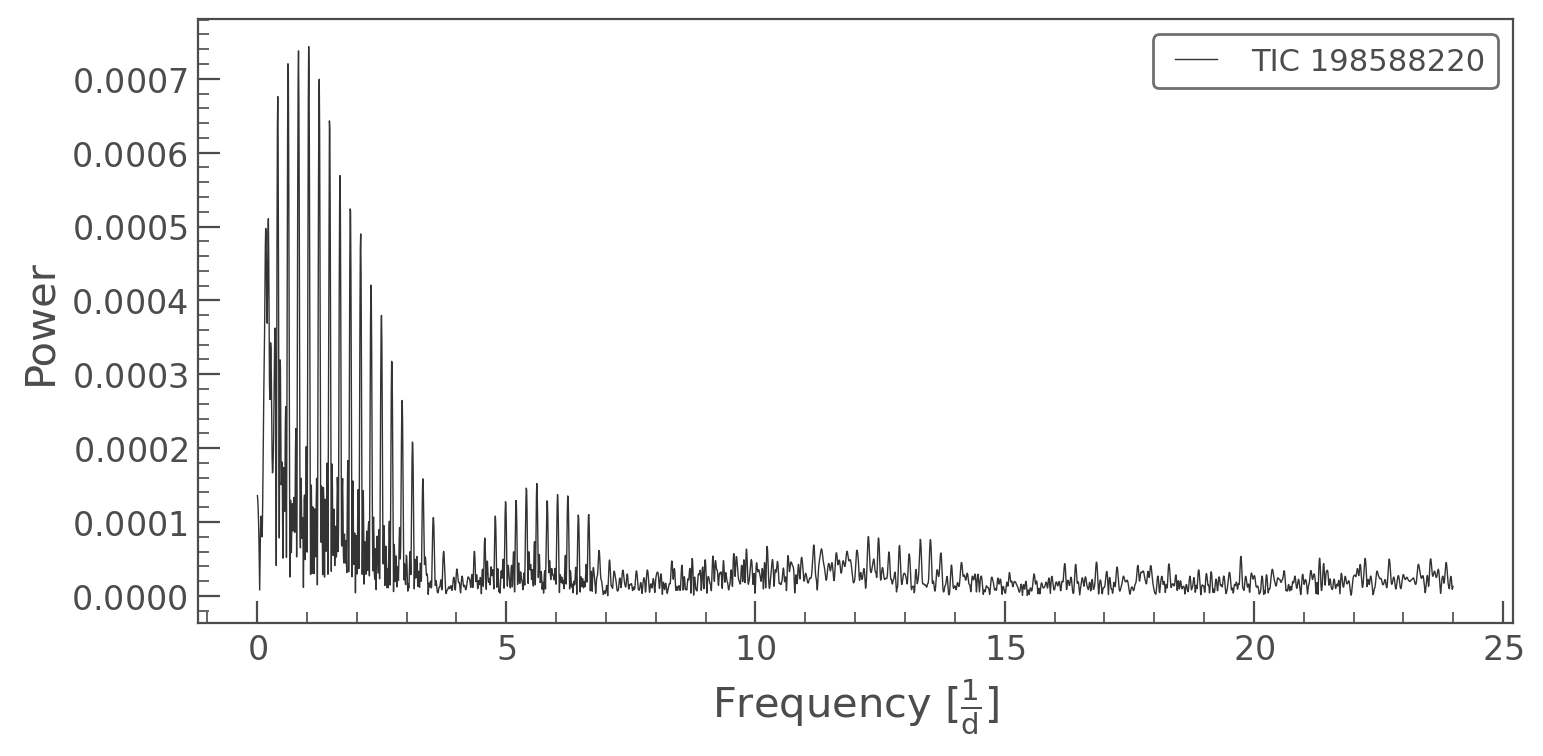

In [21]:
pg.plot();

In [22]:
period = pg.period_at_max_power
period

<Quantity 0.96488828 d>

In [23]:
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c-2457000.0

In [24]:
lc_folded = lc_raw.fold(period=orbital_period, epoch_time=t_c_btjd).normalize()

/home/gully/miniconda3/envs/disperse_env/lib/python3.8/site-packages/lightkurve/lightcurve.py:990: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

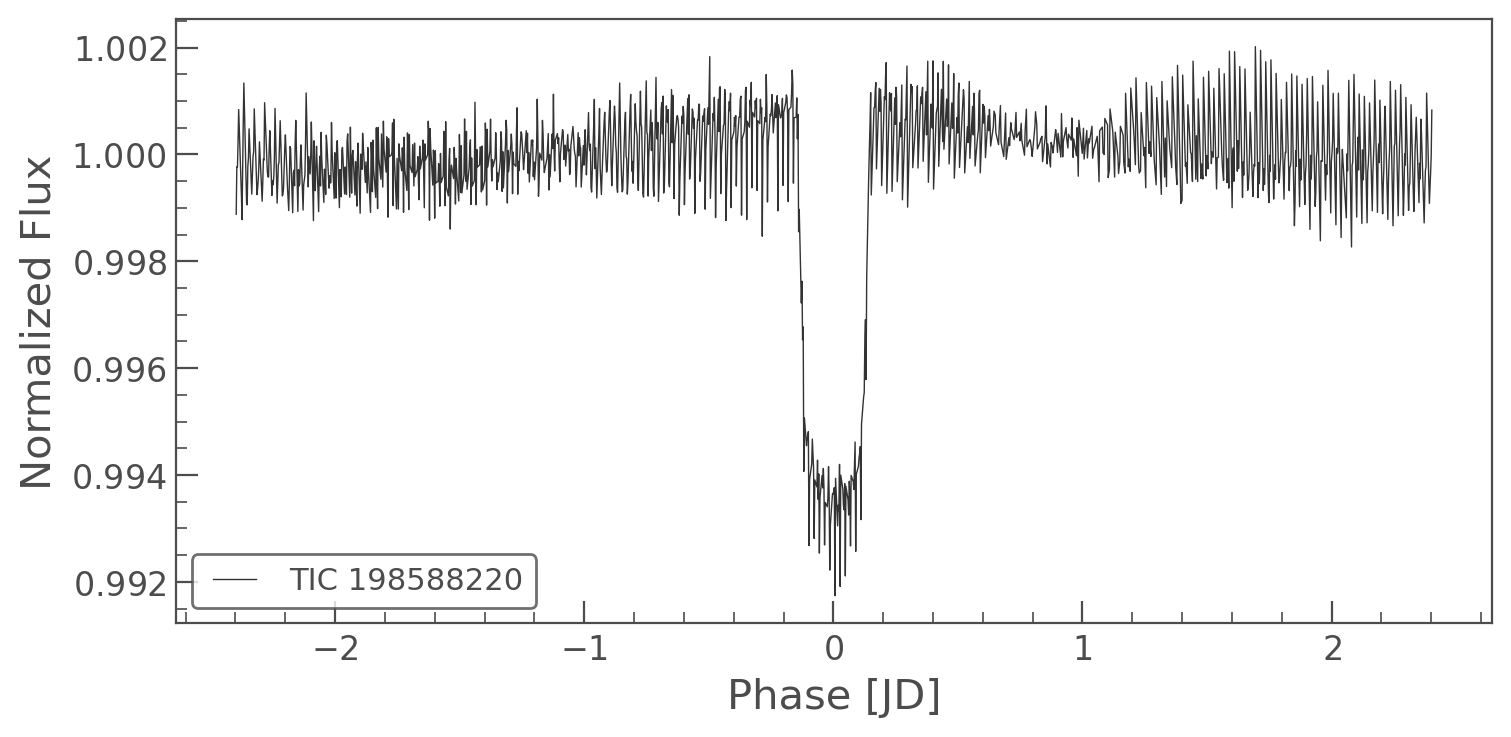

In [25]:
lc_folded.plot()

In [26]:
lc_raw2 = sr[0].download()

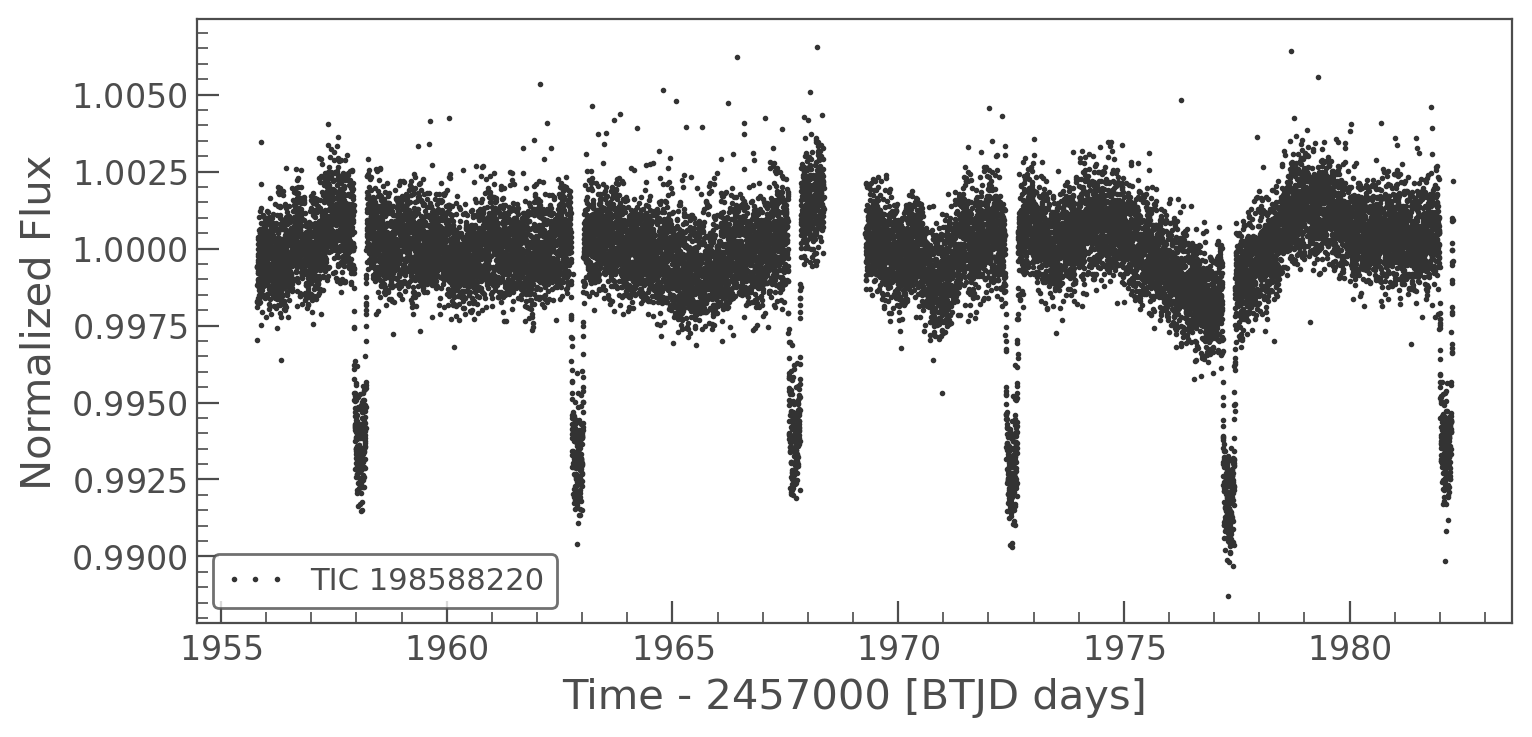

In [27]:
ax = lc_raw2.normalize().plot(marker='.', linestyle='none')
#ax.set_ylim(0, 1.05)

In [28]:
lc_flat = lc_raw2.flatten(window_length=1621)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

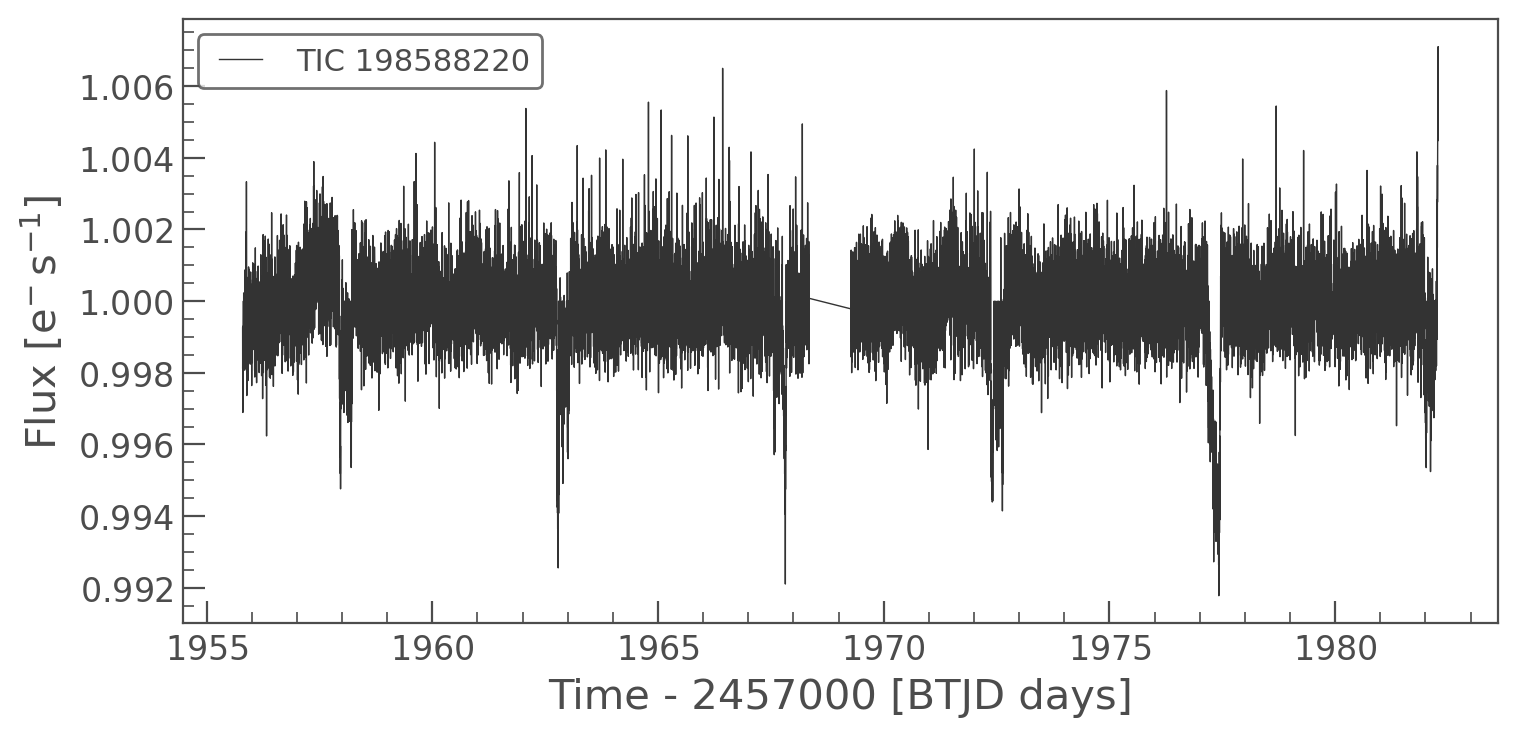

In [29]:
lc_flat.plot()

In [30]:
lc_folded2 = lc_raw2.fold(period=orbital_period, epoch_time=t_c_btjd).normalize()

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

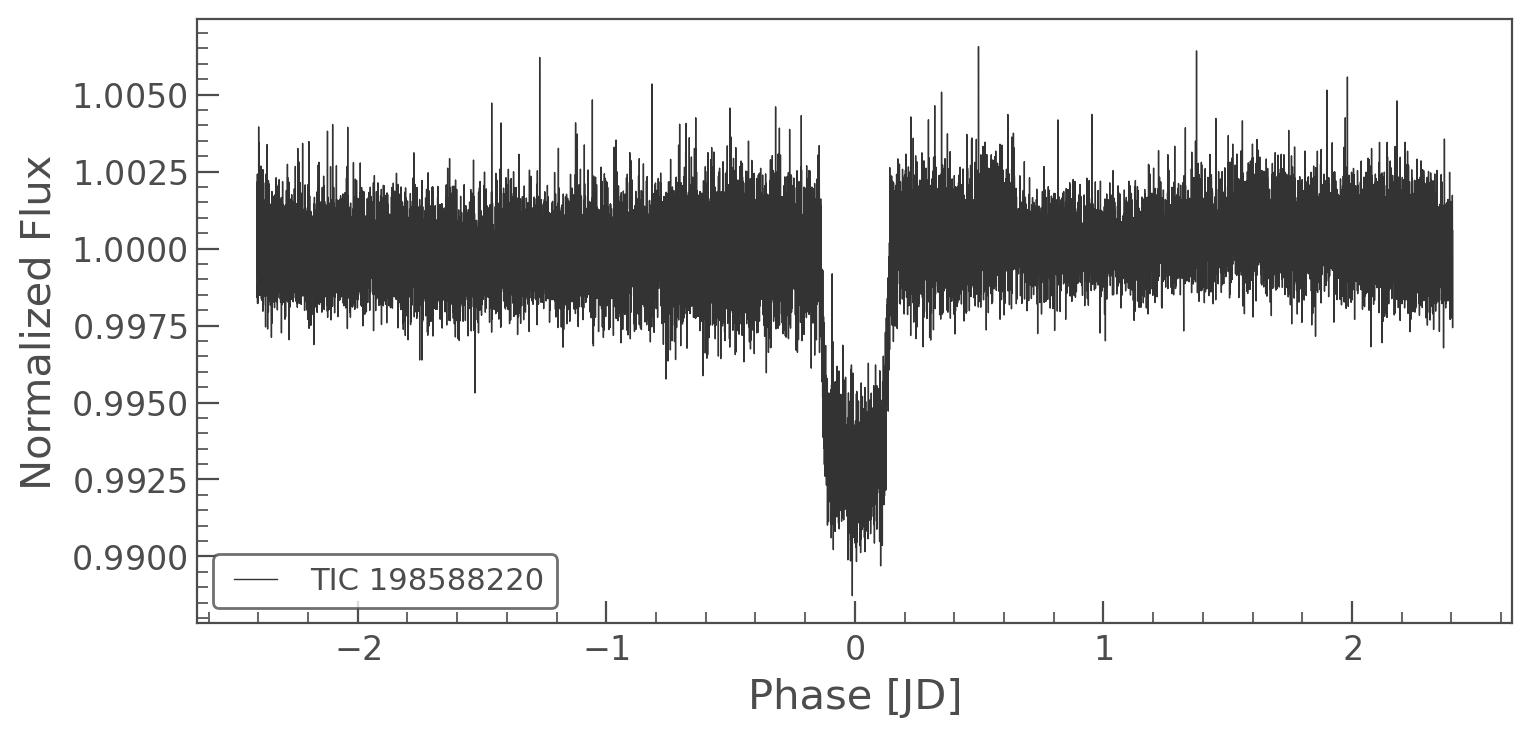

In [31]:
lc_folded2.plot()